In [669]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import time
import pickle
import colorama

# Data Extraction

In [637]:
# Read the image as gray_scale image
Oimg = cv2.imread('sudoku_samples/26.jpg',0)

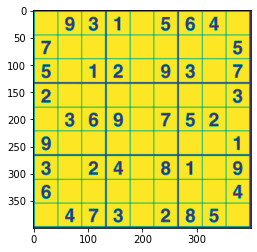

In [638]:
plt.imshow(Oimg)
plt.show()

In [639]:
Oimg.shape

(400, 400)

# Preprocessing

In [640]:
# Resize it to 600*600
Rimg=cv2.resize(Oimg,(600,600))
# convert gray scale image to binary
threshold,Bimg=cv2.threshold(Rimg,200,255,cv2.THRESH_BINARY)
# convert binary to inverse binary
IBimg=255-Bimg
# Define Kernel
kernel=np.ones((3,3),np.uint8)
# Apply Dilation
Dimg=cv2.dilate(IBimg,kernel,iterations=1)

### Define Kernels

In [641]:
kernel_length=7

In [642]:
# Defining Verticle Kernel
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
# Defining Verticle Kernel
horizontal_kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(kernel_length,1))

In [643]:
print(verticle_kernel.shape)
verticle_kernel

(7, 1)


array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

In [644]:
print(horizontal_kernel.shape)
horizontal_kernel

(1, 7)


array([[1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

### Find Verticle lines

In [645]:
# Open verticle lines by eroding or Remove horizontal lines
temp=cv2.erode(Dimg,verticle_kernel,iterations=2)
verticle_lines=cv2.dilate(temp,kernel,iterations=1)

### Find Horizontal lines

In [646]:
# Open Horizontal lines by eroding or Removing verticle lines
temp=cv2.erode(Dimg,horizontal_kernel,iterations=2)
horizontal_lines=cv2.dilate(temp,kernel,iterations=1)

### Add these two images using weights

In [647]:
a=0.5
b=0.5
final_image=cv2.addWeighted(verticle_lines,a,horizontal_lines,b,0)
final_image=cv2.erode(final_image,kernel,iterations=1)

thresh,Bfinal=cv2.threshold(final_image,120,255,cv2.THRESH_BINARY)
# IBfinal=255-final_bin

### Find Contours in image

In [648]:
# Sort Contours (top to bottom) (https://www.pyimagesearch.com/2015/04/20/sorting-contours-using-python-and-opencv/)
def sort_contours(cnts):
	reverse = False
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][1], reverse=reverse))
	return (cnts, boundingBoxes)

In [649]:
# Find contours for image, which will detect all the boxes
contours, hierarchy = cv2.findContours(Bfinal, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Sort all the contours by top to bottom.
(contours, boundingBoxes) = sort_contours(contours)

### Crop original image into 81 parts and save in cropped folder

In [650]:
for file in os.listdir('cropped'):
    os.remove('cropped/'+file)

idx = 0
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
#     print(w,h)
    if w>=Rimg.shape[0]//15 and w<=Rimg.shape[0]//8 and h>=Rimg.shape[1]//15 and h<=Rimg.shape[1]//8:
#         print(w,h)
#         cv2.rectangle(Oimg,(x,y),(x+w,y+h),(0,255),3)
        idx += 1
        new_img = Rimg[y:y+h, x:x+w]
        new_img=cv2.resize(new_img,(28,28))
        cv2.imwrite('./cropped/'+str(idx)+'.jpeg', new_img)

# Text Identification

In [651]:
# To load model again
model=pickle.load(open('final_model.sav','rb'))

In [652]:
# get data from cropped images using our model
array=[]
for i in range(1,82):
    img=cv2.imread('cropped/{}.jpeg'.format(i),0)
    i_img=255-img
    flat_img=(i_img.ravel()).reshape(1,-1).tolist()
    array.append(model.predict(flat_img)[0])

In [653]:
np.array(array).reshape(9,9)

array([[0, 4, 6, 5, 0, 1, 3, 9, 0],
       [5, 0, 0, 0, 0, 0, 0, 0, 7],
       [7, 0, 3, 9, 0, 2, 1, 0, 5],
       [3, 0, 0, 0, 0, 0, 0, 0, 2],
       [0, 2, 5, 7, 0, 9, 6, 3, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 9],
       [9, 0, 1, 8, 0, 4, 2, 0, 3],
       [4, 0, 0, 0, 0, 0, 0, 0, 6],
       [0, 5, 8, 2, 0, 3, 7, 4, 0]])

In [654]:
# re-arrange numbers
input_array=[]
for i in range(9):
    for j in range(8,-1,-1):
        input_array.append(array[j])
    del array[0:9]

In [655]:
np.array(input_array).reshape(9,9)

array([[0, 9, 3, 1, 0, 5, 6, 4, 0],
       [7, 0, 0, 0, 0, 0, 0, 0, 5],
       [5, 0, 1, 2, 0, 9, 3, 0, 7],
       [2, 0, 0, 0, 0, 0, 0, 0, 3],
       [0, 3, 6, 9, 0, 7, 5, 2, 0],
       [9, 0, 0, 0, 0, 0, 0, 0, 1],
       [3, 0, 2, 4, 0, 8, 1, 0, 9],
       [6, 0, 0, 0, 0, 0, 0, 0, 4],
       [0, 4, 7, 3, 0, 2, 8, 5, 0]])

# Solving The Puzzle

In [656]:
cell='123456789'

solution=pd.DataFrame(data=cell,columns=np.arange(0,9),index=np.arange(0,9))

matrix=np.array([str(i) for i in input_array]).reshape(9,9)

result=matrix.copy()

g1=[(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)]
g2=[(3,0),(3,1),(3,2),(4,0),(4,1),(4,2),(5,0),(5,1),(5,2)]
g3=[(6,0),(6,1),(6,2),(7,0),(7,1),(7,2),(8,0),(8,1),(8,2)]
g4=[(0,3),(0,4),(0,5),(1,3),(1,4),(1,5),(2,3),(2,4),(2,5)]
g5=[(3,3),(3,4),(3,5),(4,3),(4,4),(4,5),(5,3),(5,4),(5,5)]
g6=[(6,3),(6,4),(6,5),(7,3),(7,4),(7,5),(8,3),(8,4),(8,5)]
g7=[(0,6),(0,7),(0,8),(1,6),(1,7),(1,8),(2,6),(2,7),(2,8)]
g8=[(3,6),(3,7),(3,8),(4,6),(4,7),(4,8),(5,6),(5,7),(5,8)]
g9=[(6,6),(6,7),(6,8),(7,6),(7,7),(7,8),(8,6),(8,7),(8,8)]
group={'g1':g1,'g2':g2,'g3':g3,'g4':g4,'g4':g5,'g6':g6,'g7':g7,'g8':g8,'g9':g9}

In [657]:
#remove digits from rows and columns from solution if result matrix has that digit in a specific cell
def fun1():
    for i in range(9):
        for j in range(9):
            if result[i,j]!='0':
                solution.loc[i,:]=solution.loc[i,:].apply(lambda x:x.replace(matrix[i,j],''))
                solution.loc[:,j]=solution.loc[:,j].apply(lambda x:x.replace(matrix[i,j],''))
                solution.loc[i,j]='0' # result of this cell is achieved

In [658]:
# if only 1 digit is left in solution'cell than fix it on that position and remove from row and column
def fun2():
    for i in range(0,9):
        for j in range(0,9):
            if solution.loc[i,j]!='0' and len(solution.loc[i,j])==1:
                temp=True
                nc=solution.loc[i,j]
                result[i,j]=solution.loc[i,j]
                solution.loc[i,:]=solution.loc[i,:].apply(lambda x:x.replace(nc,''))
                solution.loc[:,j]=solution.loc[:,j].apply(lambda x:x.replace(nc,''))
                solution.loc[i,j]='0'
    temp=False
    return(temp)

In [659]:
def fun3():
    for g in group.values():
        for ind in g:
            if result[ind[0],ind[1]]!='0':
                for i in g:
                    solution.loc[i[0],i[1]]=solution.loc[i[0],i[1]].replace(result[ind[0],ind[1]],'')



    for g in group.values():
        st=''

        for index in g:
            st=st+solution.loc[index[0],index[1]]
        st=st.replace('0','')
    #     print(st)
        for i in range(1,10):
            if st.count(str(i))==1:
    #             print(i)
                for ind in g:
                    if str(i) in solution.loc[ind[0],ind[1]]:
    #                     print(ind)
                        solution.loc[ind[0],ind[1]]=str(i)

In [678]:
def solve():
    t=time.time()
    while True:
        if time.time()-t>=5:
            print('Try a Simpler One')
            break
        fun1()
        res=fun2()
        if res==False:
            fun3()
        else:
            res=fun2()
        st=''
        number_list=[]
        for i in range(9):
            for j in range(9):
                number_list.append(result[i,j])
        if '0' not in number_list:
            return(result)

In [680]:
solution=solve()

In [695]:
solution

array([['8', '9', '3', '1', '7', '5', '6', '4', '2'],
       ['7', '2', '4', '8', '3', '6', '9', '1', '5'],
       ['5', '6', '1', '2', '4', '9', '3', '8', '7'],
       ['2', '1', '5', '6', '8', '4', '7', '9', '3'],
       ['4', '3', '6', '9', '1', '7', '5', '2', '8'],
       ['9', '7', '8', '5', '2', '3', '4', '6', '1'],
       ['3', '5', '2', '4', '6', '8', '1', '7', '9'],
       ['6', '8', '9', '7', '5', '1', '2', '3', '4'],
       ['1', '4', '7', '3', '9', '2', '8', '5', '6']], dtype='<U1')